# Library

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import f_oneway, zscore
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from wordcloud import WordCloud
import missingno as msno
import scipy.stats as stats

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


# Load data

In [32]:
df = pd.read_csv('../data/raw/data_capstone.csv')

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# EDA

## 1. MISSING VALUE Heatmap

In [33]:
def eda_missing_full(df):
    print("===== EDA MISSING VALUES & DUPLICATION CHECK =====\n")
    
    print(">>> Ringkasan Missing Values per Kolom:\n")
    print(df.isnull().sum(), "\n")

    print(f"Total Missing Values: {df.isnull().sum().sum()}\n")

    print(">>> Plot 1: Missing Values Heatmap (Seaborn)\n")
    plt.figure(figsize=(12, 5))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap (Seaborn)")
    plt.show()

    print(">>> Plot 2: Missing Value Matrix (missingno)\n")
    msno.matrix(df)
    plt.title("Missing Value Matrix")
    plt.show()

    print(">>> Plot 3: Missing Value Count per Feature (missingno)\n")
    msno.bar(df)
    plt.title("Missing Value Count per Feature")
    plt.show()

    print(">>> Plot 4: Missing Value Correlation Heatmap (missingno)\n")
    try:
        msno.heatmap(df)
        plt.title("Missing Value Correlation Heatmap")
        plt.show()
    except:
        print("Missingno heatmap tidak dapat dihitung.")


>>> Mengecek duplikasi baris...

Tidak ada baris duplikat.

===== EDA MISSING VALUES & DUPLICATION CHECK =====

>>> Ringkasan Missing Values per Kolom:

customer_id          0
plan_type            0
device_brand         0
avg_data_usage_gb    0
pct_video_usage      0
avg_call_duration    0
sms_freq             0
monthly_spend        0
topup_freq           0
travel_score         0
complaint_count      0
target_offer         0
dtype: int64 

Total Missing Values: 0

>>> Plot 1: Missing Values Heatmap (Seaborn)



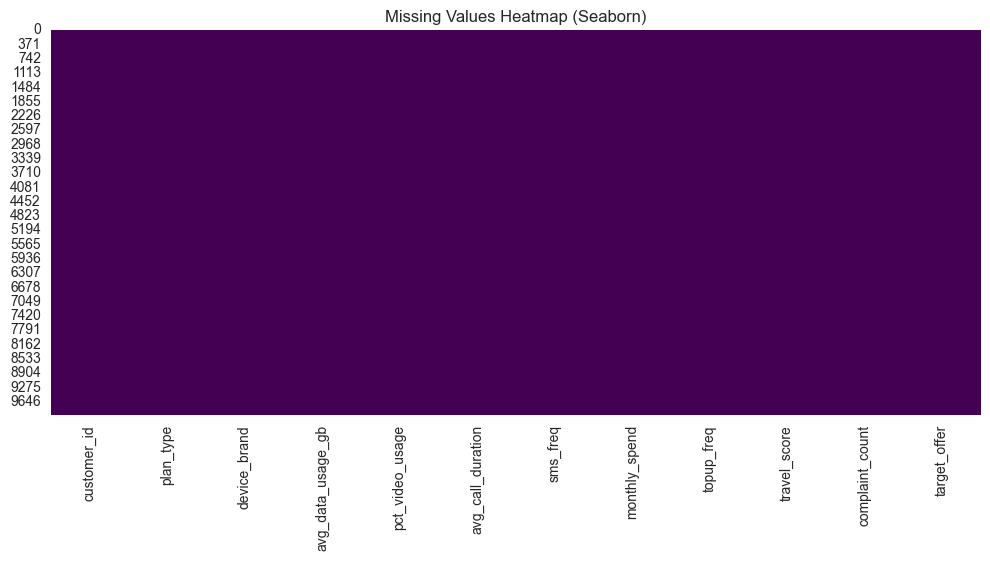

>>> Plot 2: Missing Value Matrix (missingno)



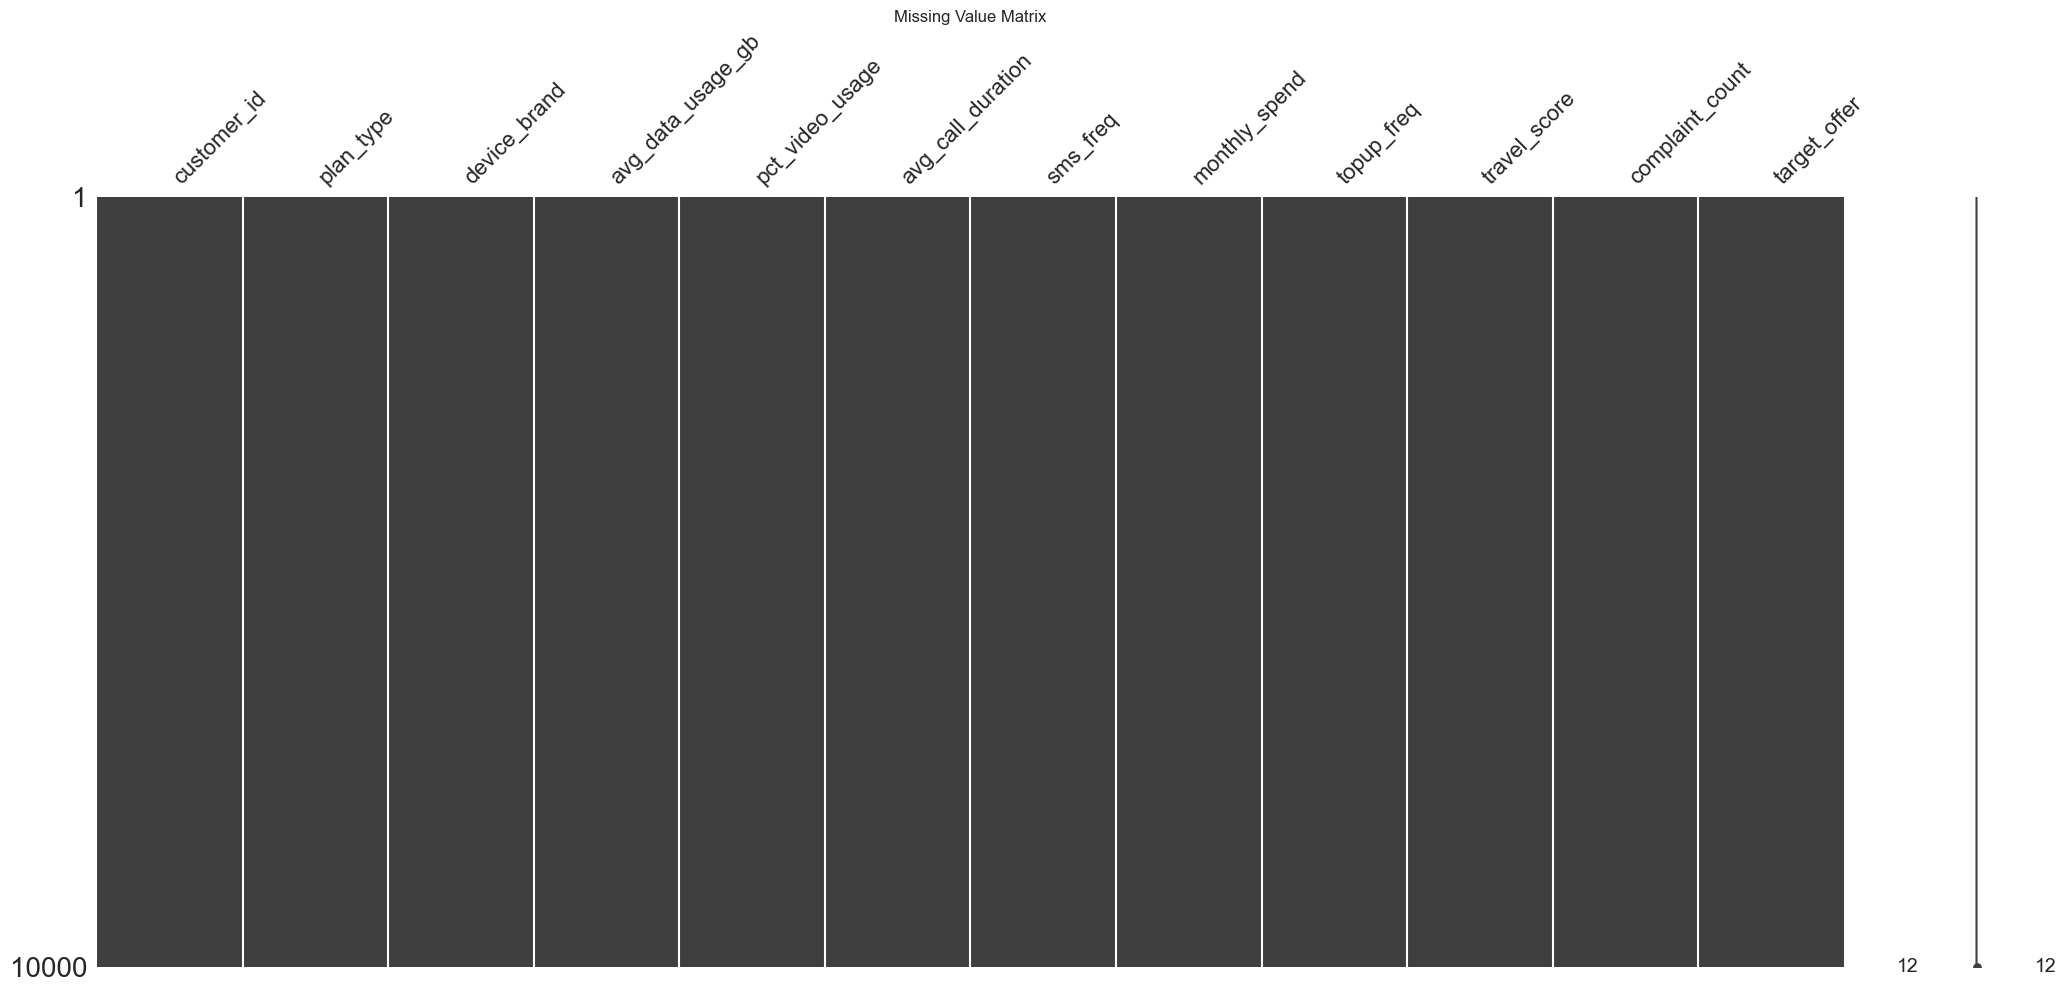

>>> Plot 3: Missing Value Count per Feature (missingno)



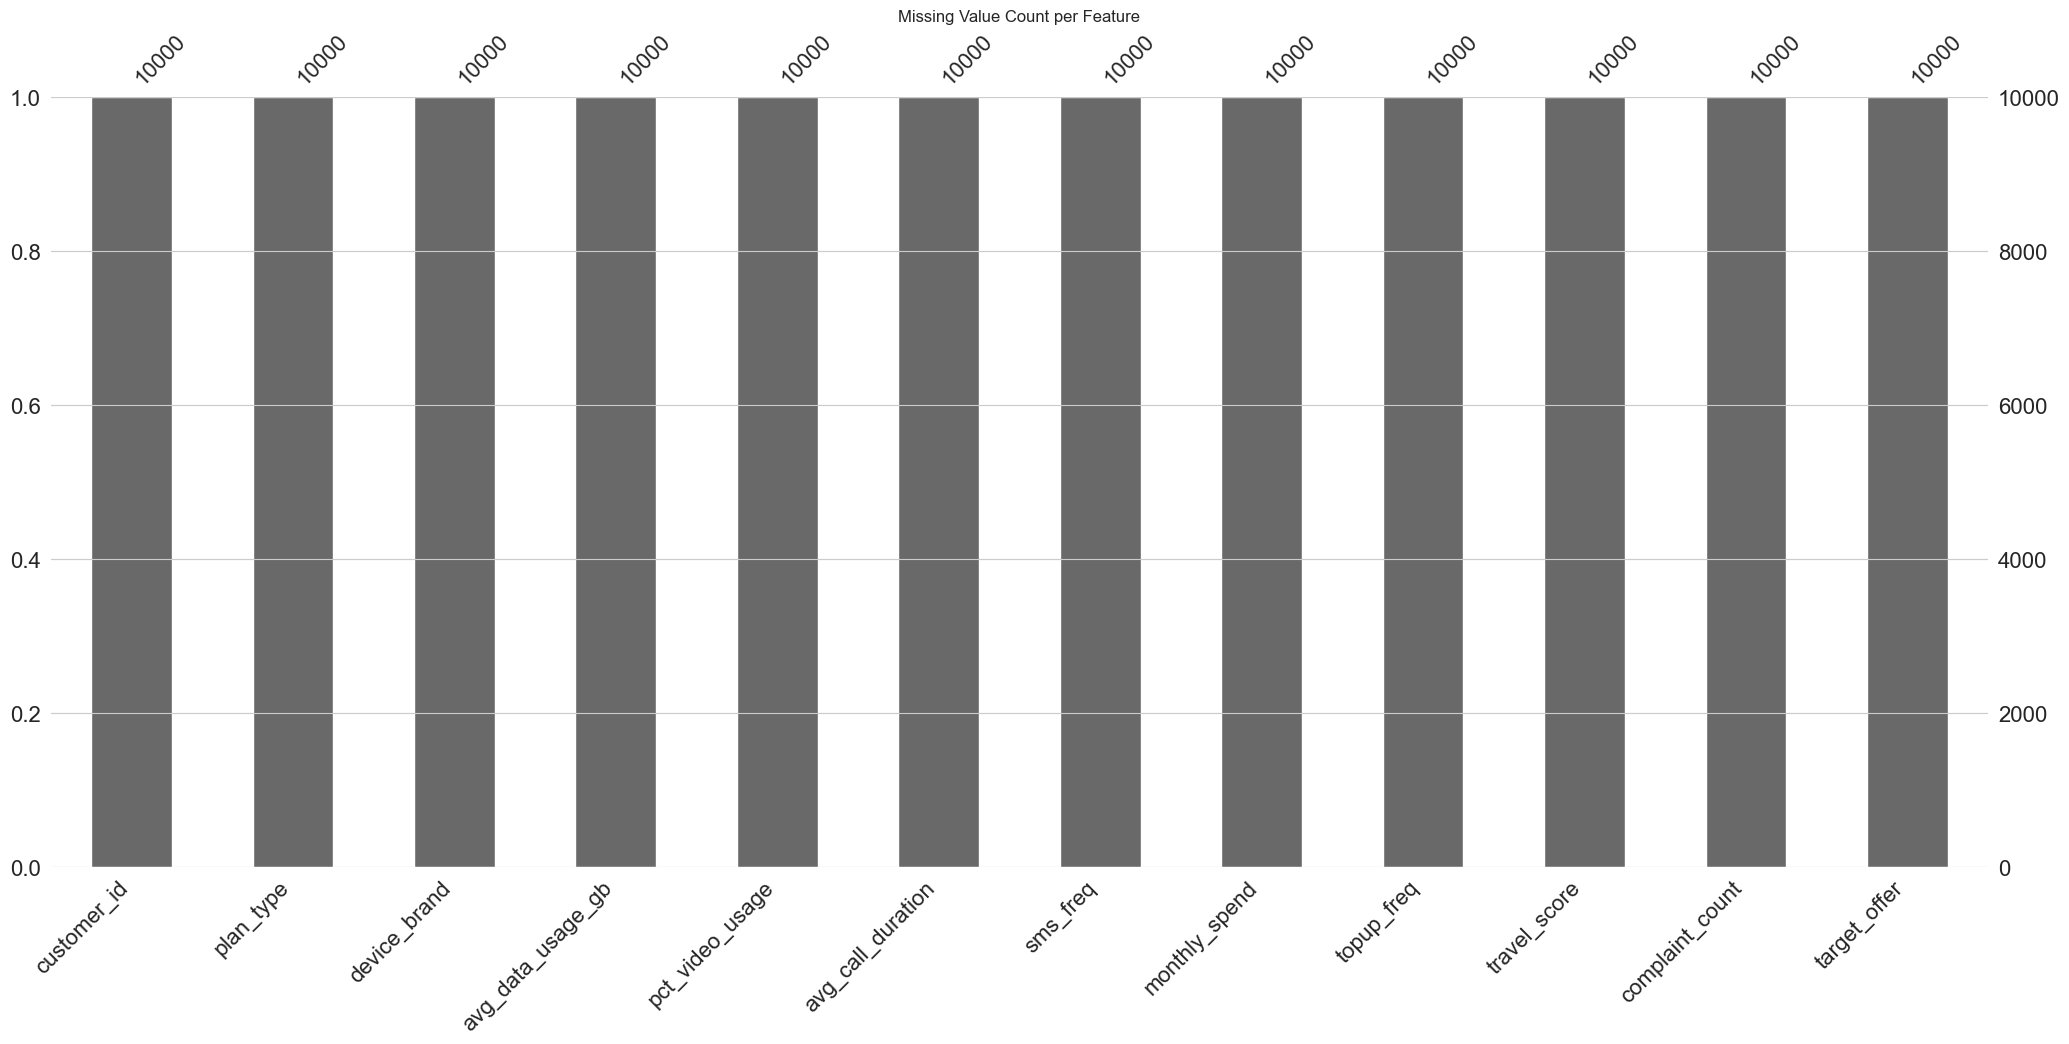

>>> Plot 4: Missing Value Correlation Heatmap (missingno)



c:\Users\Asus\Documents\ASAH 2025\CAPSTONE\.venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\Asus\Documents\ASAH 2025\CAPSTONE\.venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


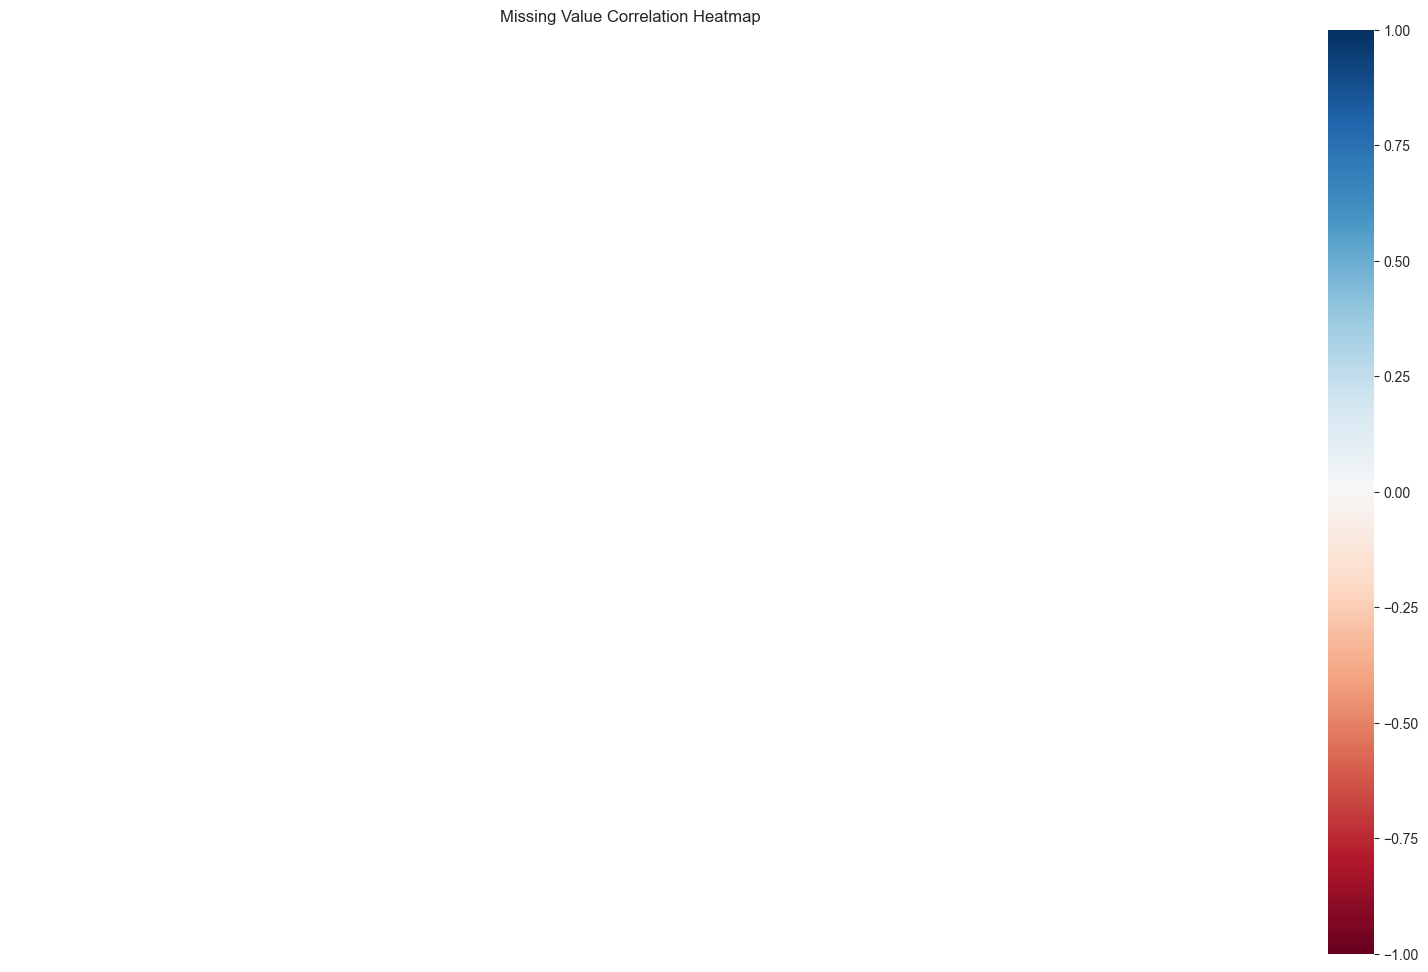

In [ ]:
# Duplicate check
print("\n>>> Mengecek duplikasi baris...\n")
dupe_mask = df.duplicated(keep=False)
dupes = df[dupe_mask]

if dupes.empty:
    print("Tidak ada baris duplikat.\n")
else:
    print(f"Ditemukan {dupes.shape[0]} baris duplikat.\n")
    print(">>> Plot 5: Duplicate Row Heatmap\n")

    plt.figure(figsize=(14, 4))
    sns.heatmap(dupes.isnull(), cbar=False, cmap="Reds")
    plt.title("Duplicate Row Heatmap (Only on Duplicate Rows)")
    plt.show()

In [ ]:
eda_missing_full(df)

## 2. DISTRIBUSI NUMERIK

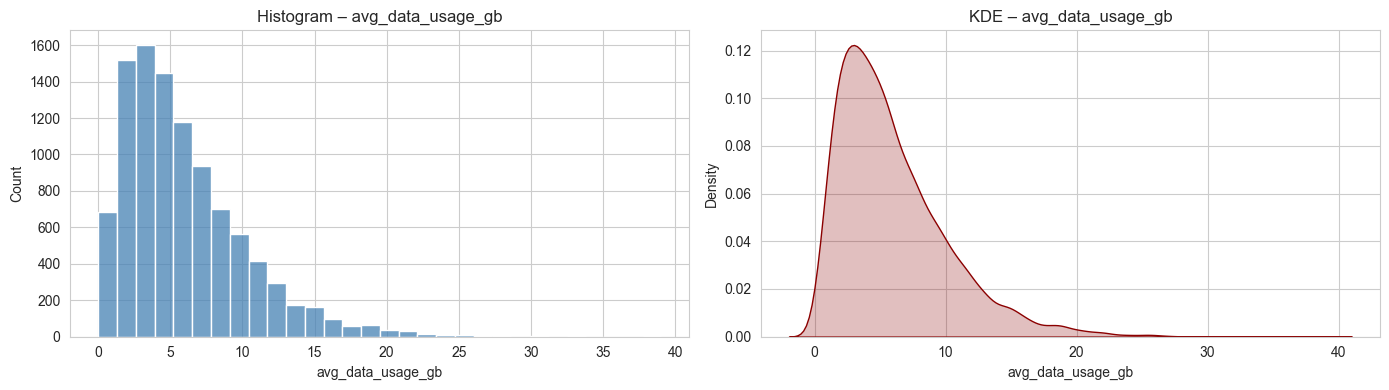

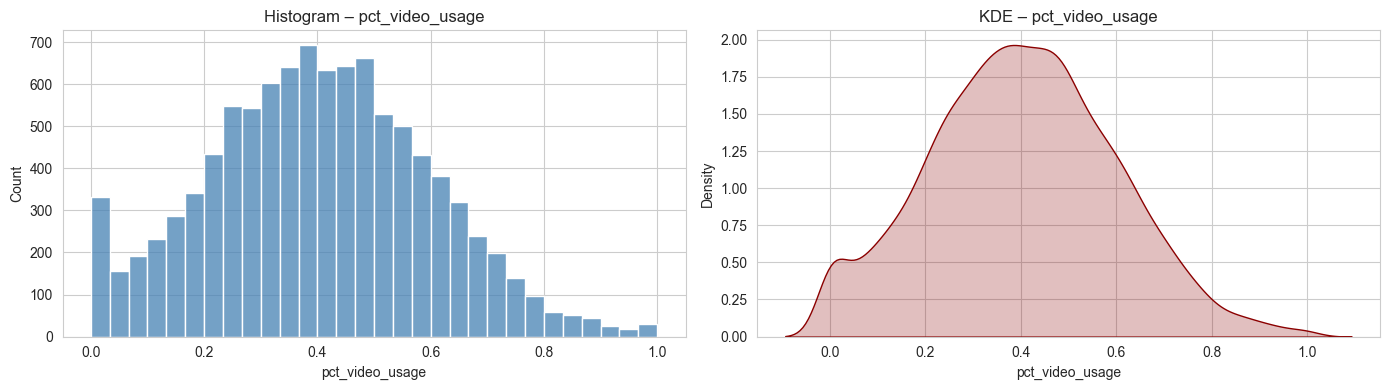

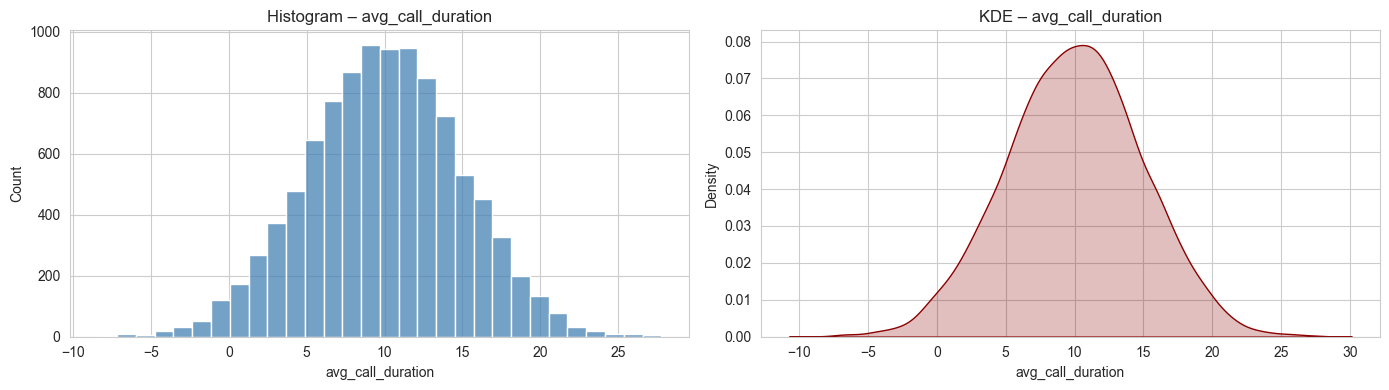

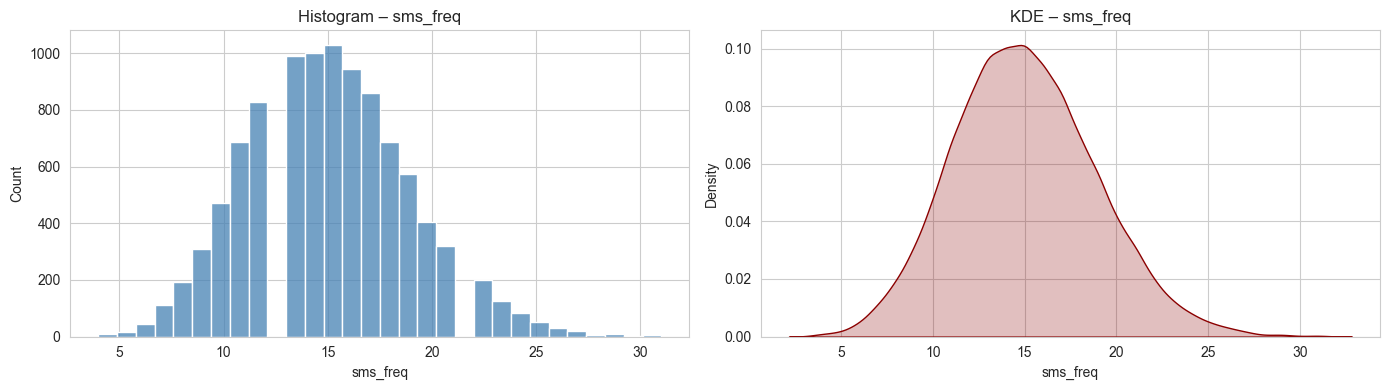

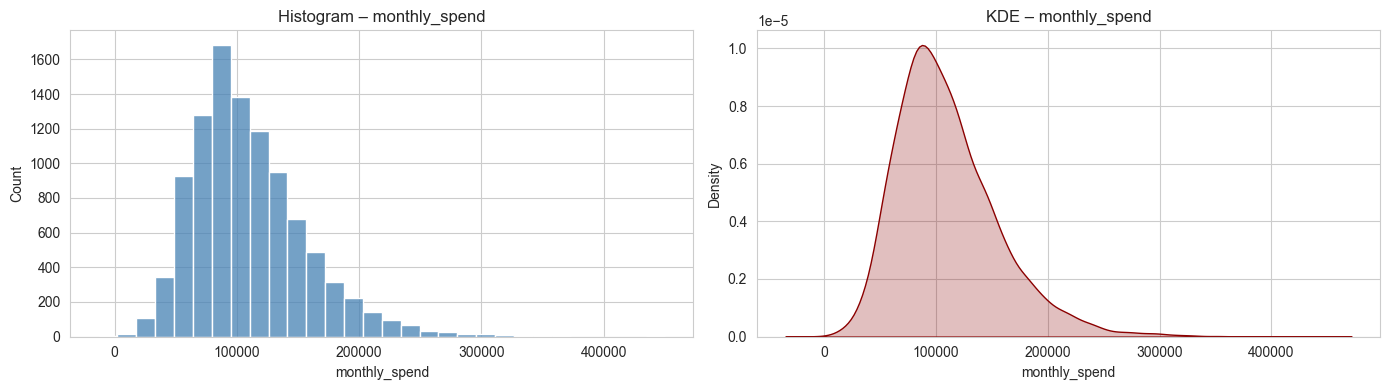

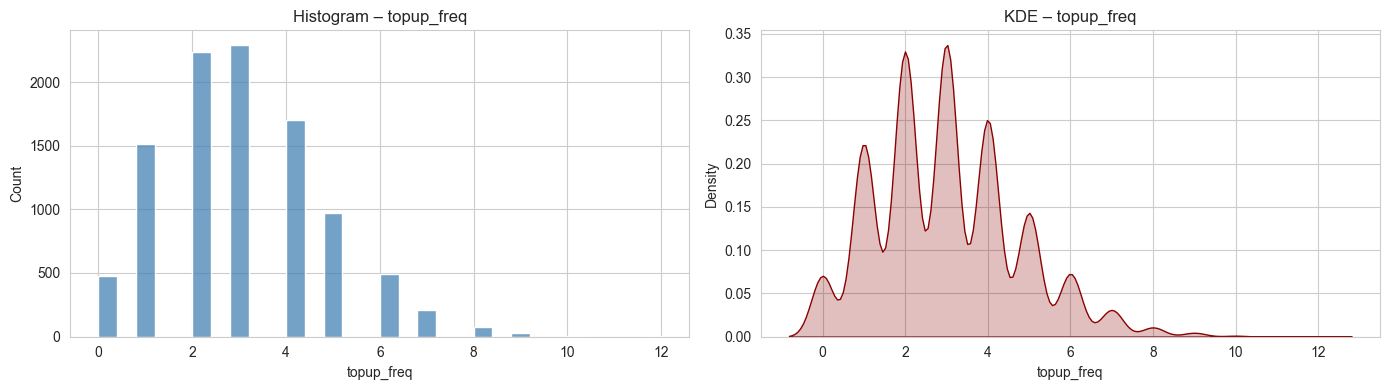

In [35]:
def plot_numeric_distributions(df, numeric_cols):
    for col in numeric_cols:
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))

        sns.histplot(df[col], kde=False, ax=ax[0], color="steelblue", bins=30)
        ax[0].set_title(f"Histogram – {col}")

        sns.kdeplot(df[col], fill=True, ax=ax[1], color="darkred")
        ax[1].set_title(f"KDE – {col}")

        plt.tight_layout()
        plt.show()

plot_numeric_distributions(df, numeric_cols[:6])

## 3. DISTRIBUSI KATEGORIKAL

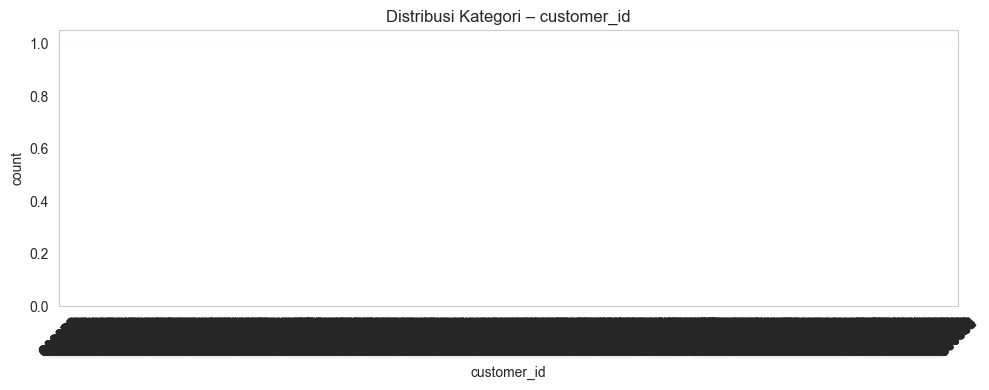

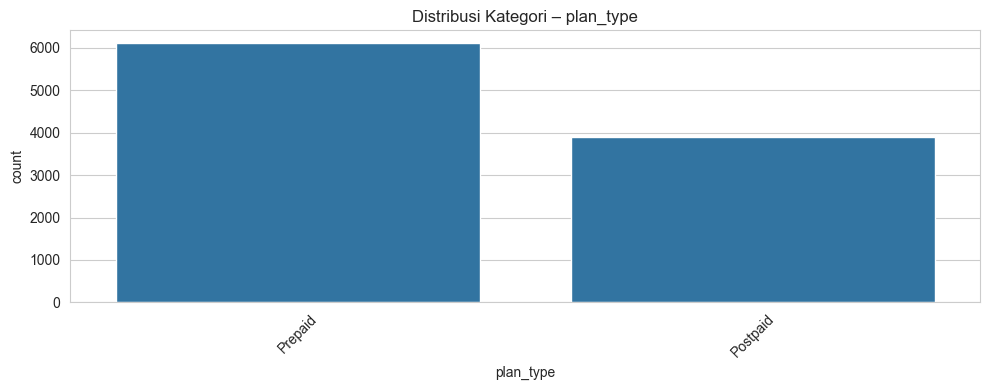

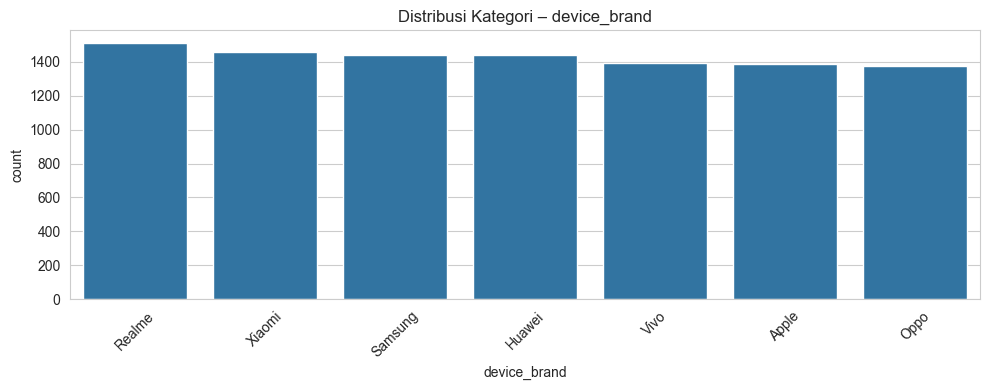

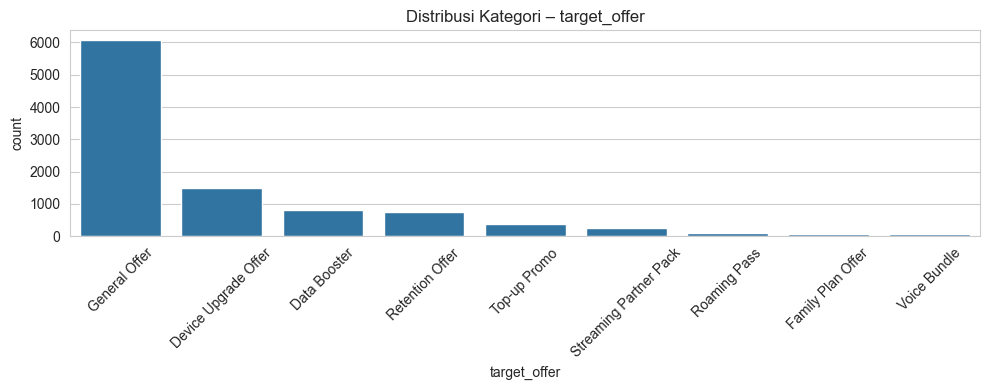

In [36]:
def plot_categorical(df, cat_cols):
    for col in cat_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Distribusi Kategori – {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_categorical(df, cat_cols)


## 4. ANOVA SIGNIFICANCE TEST

In [37]:
def compute_anova(df, numeric_cols, target):
    results = {}
    for col in numeric_cols:
        groups = [group[col].dropna() for _, group in df.groupby(target)]
        try:
            _, p_val = f_oneway(*groups)
            results[col] = p_val
        except:
            results[col] = np.nan

    return pd.DataFrame.from_dict(results, orient='index', columns=['p_value']).sort_values("p_value")

anova_results = compute_anova(df, numeric_cols, 'target_offer')
print("\n=== Top Features Paling Signifikan (ANOVA) ===")
print(anova_results.head())



=== Top Features Paling Signifikan (ANOVA) ===
                         p_value
avg_data_usage_gb   0.000000e+00
pct_video_usage     0.000000e+00
monthly_spend       0.000000e+00
complaint_count     0.000000e+00
travel_score       1.460429e-181


## 5. PCA 2D

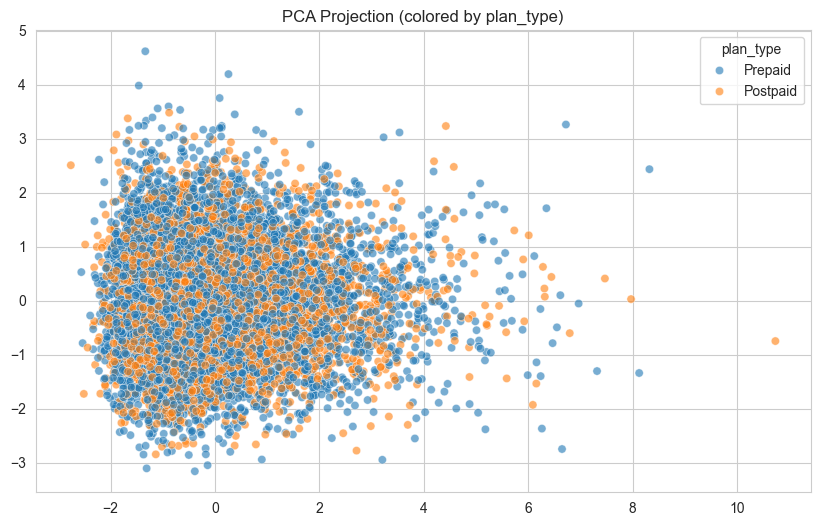

In [38]:
def pca_plot(df, numeric_cols, label_col):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[numeric_cols])

    pcs = PCA(n_components=2).fit_transform(scaled)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], hue=df[label_col], alpha=0.6)
    plt.title(f"PCA Projection (colored by {label_col})")
    plt.show()

pca_plot(df, numeric_cols, 'plan_type')

## 6. MULTICOLLINEARITY (VIF)

In [39]:
def compute_vif(df, numeric_cols):
    vif_df = pd.DataFrame()
    vif_df["feature"] = numeric_cols
    vif_df["VIF"] = [
        variance_inflation_factor(df[numeric_cols].values, i)
        for i in range(len(numeric_cols))
    ]
    return vif_df.sort_values("VIF", ascending=False)

print("\n=== VIF (Multicollinearity Check) ===")
print(compute_vif(df, numeric_cols))


=== VIF (Multicollinearity Check) ===
             feature        VIF
4      monthly_spend  29.522502
0  avg_data_usage_gb  14.947755
3           sms_freq  10.151626
1    pct_video_usage   4.698680
2  avg_call_duration   4.526472
6       travel_score   3.858773
5         topup_freq   3.740263
7    complaint_count   1.469061


## 7. OUTLIER DETECTION

In [40]:
def detect_outliers(df, numeric_cols):
    return pd.Series({
        col: (np.abs(zscore(df[col].dropna())) > 3).sum()
        for col in numeric_cols
    }).sort_values(ascending=False)

print("\n=== Jumlah Outlier (Z-score > 3) ===")
print(detect_outliers(df, numeric_cols))



=== Jumlah Outlier (Z-score > 3) ===
avg_data_usage_gb    151
complaint_count      138
monthly_spend        108
topup_freq            38
travel_score          38
sms_freq              35
avg_call_duration     31
pct_video_usage       18
dtype: int64


## 8. SEGMENTASI

C:\Users\Asus\AppData\Local\Temp\ipykernel_10900\3158303065.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='spend_segment', palette='viridis')


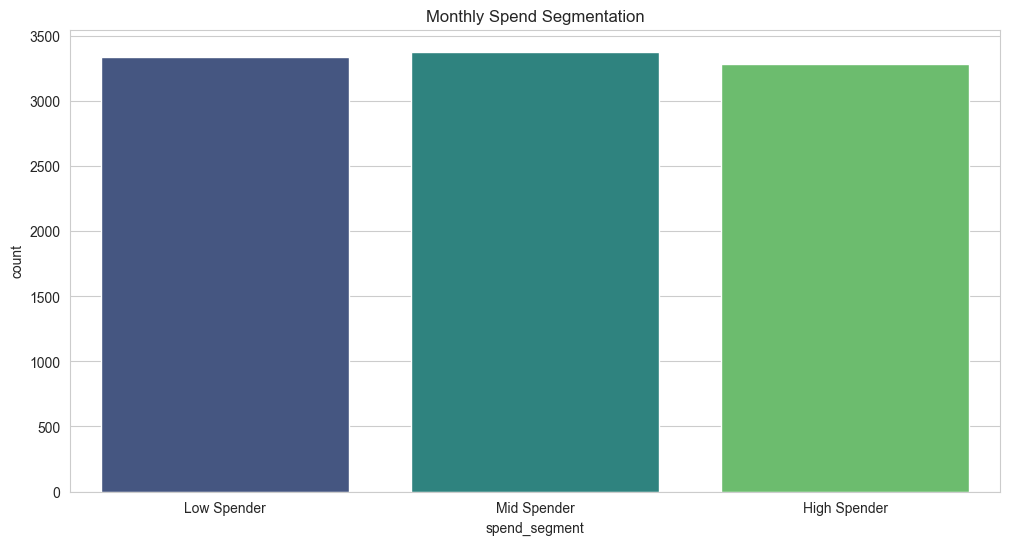

In [41]:
df['spend_segment'] = pd.qcut(
    df['monthly_spend'], q=3,
    labels=['Low Spender', 'Mid Spender', 'High Spender']
)

sns.countplot(data=df, x='spend_segment', palette='viridis')
plt.title("Monthly Spend Segmentation")
plt.show()

## 9. WORDCLOUD

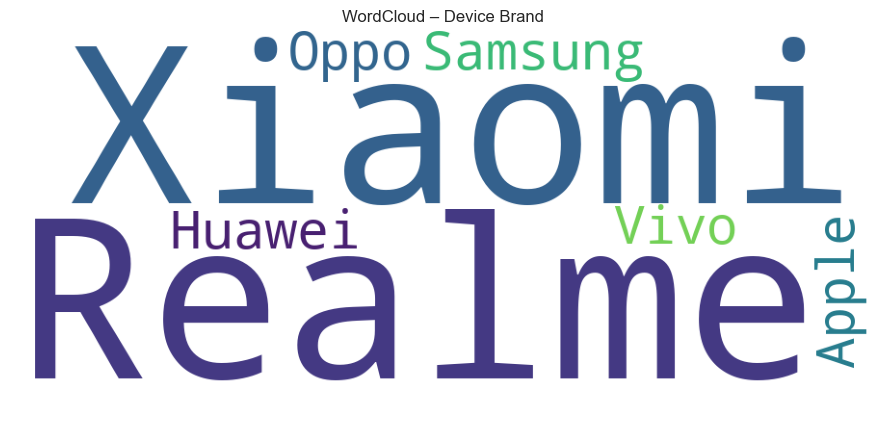

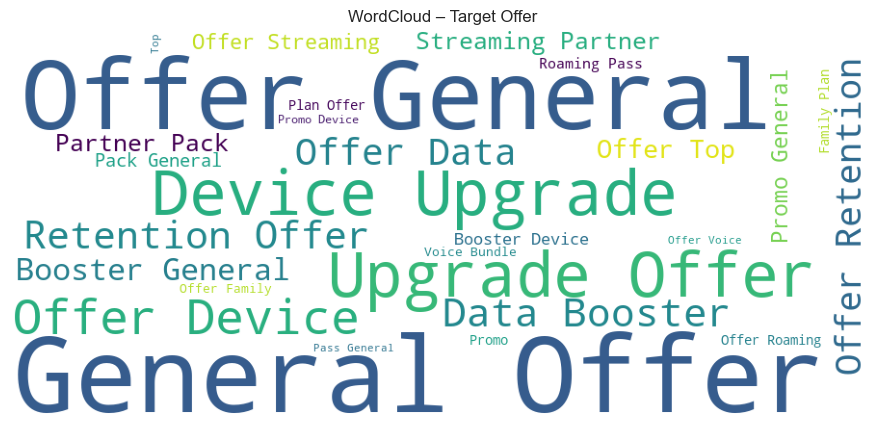

In [42]:
def plot_wordcloud(text, title):
    wc = WordCloud(width=900, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12, 5))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(" ".join(df['device_brand'].astype(str)), "WordCloud – Device Brand")
plot_wordcloud(" ".join(df['target_offer'].astype(str)), "WordCloud – Target Offer")


# 10. PAIRPLOT INTERAKSI

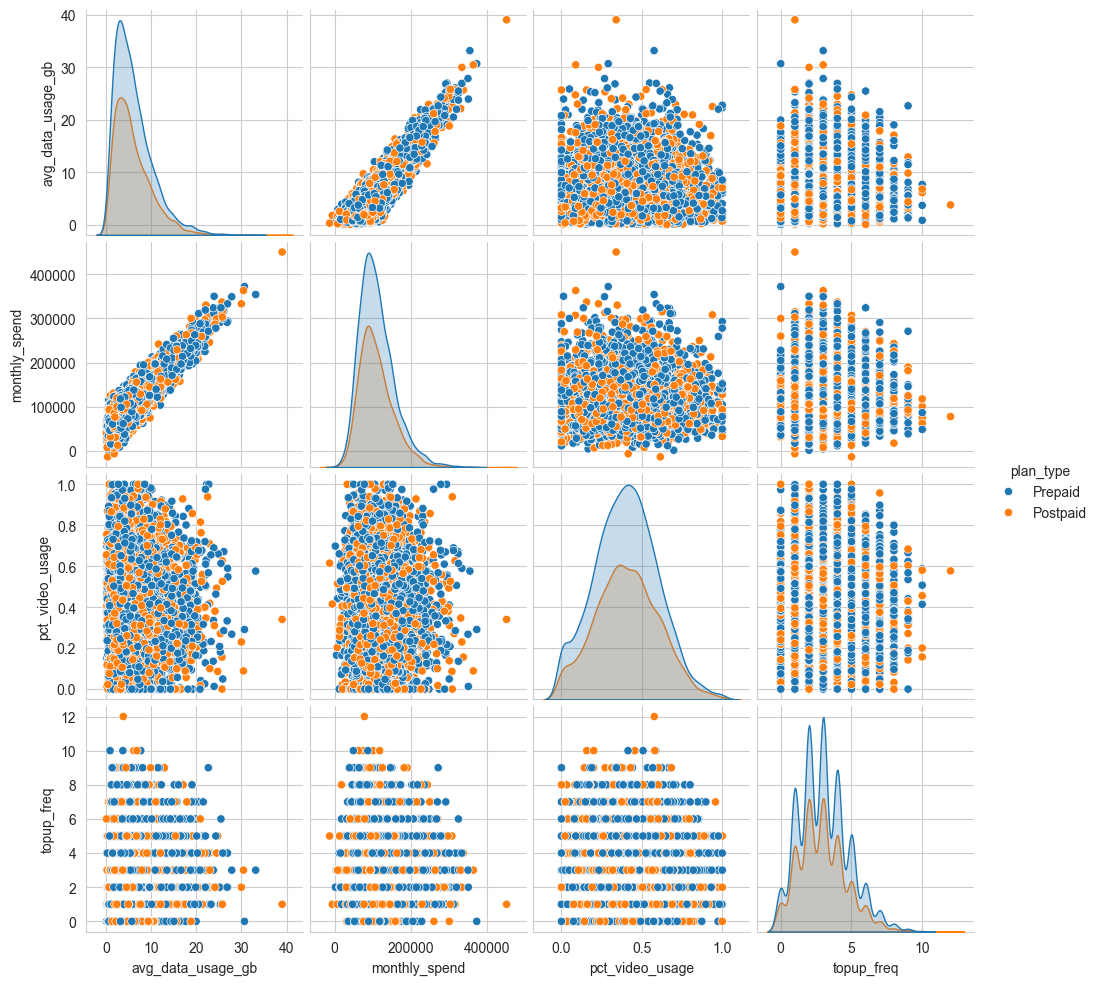

In [43]:
interaction_cols = ['avg_data_usage_gb', 'monthly_spend', 'pct_video_usage', 'topup_freq']

sns.pairplot(df[interaction_cols + ['plan_type']], hue='plan_type', diag_kind='kde')
plt.show()

## 11. MUTUAL INFORMATION


=== TOP 15 MUTUAL INFORMATION FEATURES ===
              feature  mutual_info
6       monthly_spend     0.427913
2   avg_data_usage_gb     0.311532
10      spend_segment     0.306463
9     complaint_count     0.186250
3     pct_video_usage     0.169574
1        device_brand     0.099124
8        travel_score     0.053295
4   avg_call_duration     0.035196
0           plan_type     0.032942
7          topup_freq     0.023763
5            sms_freq     0.020669


C:\Users\Asus\AppData\Local\Temp\ipykernel_10900\1526218402.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df.head(15), x='mutual_info', y='feature', palette="viridis")


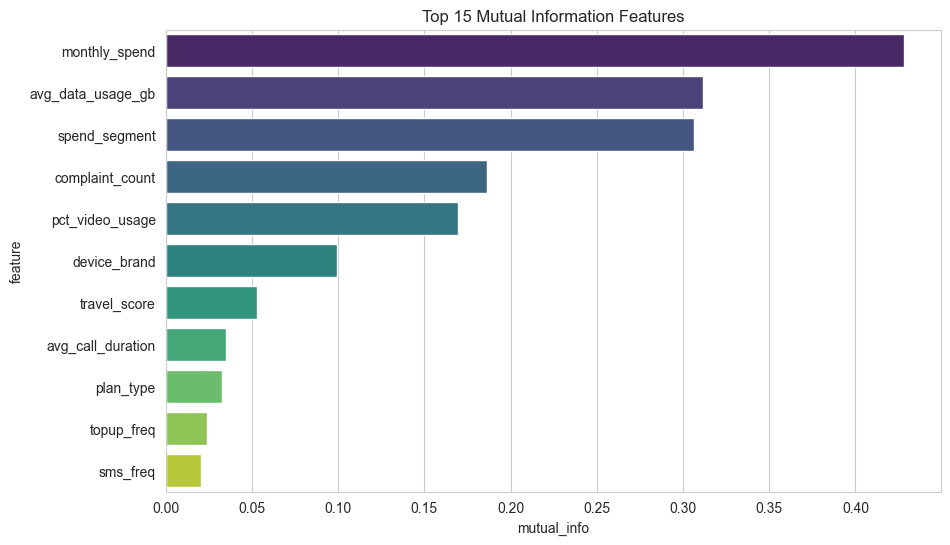

In [44]:
X = df.drop(columns=['target_offer', 'customer_id'])
y = df['target_offer']

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

enc = OrdinalEncoder()
X[cat_cols] = enc.fit_transform(X[cat_cols].astype(str))

mi_scores = mutual_info_classif(X, y, discrete_features=[X.columns.get_loc(c) for c in cat_cols])

mi_df = pd.DataFrame({"feature": X.columns, "mutual_info": mi_scores}).sort_values('mutual_info', ascending=False)

print("\n=== TOP 15 MUTUAL INFORMATION FEATURES ===")
print(mi_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=mi_df.head(15), x='mutual_info', y='feature', palette="viridis")
plt.title("Top 15 Mutual Information Features")
plt.show()


## 12. VARIANCE CHECK

C:\Users\Asus\AppData\Local\Temp\ipykernel_10900\552097368.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variances.values, y=variances.index, palette="Blues_r")


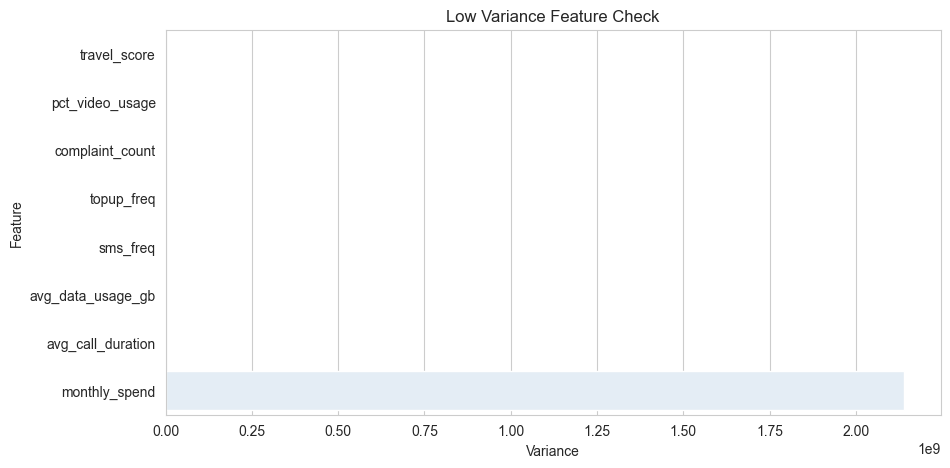

In [45]:
variances = df[num_cols].var().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=variances.values, y=variances.index, palette="Blues_r")
plt.title("Low Variance Feature Check")
plt.xlabel("Variance")
plt.ylabel("Feature")
plt.show()

## 13. SKEWNESS

C:\Users\Asus\AppData\Local\Temp\ipykernel_10900\1820429709.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skew_vals.values, y=skew_vals.index, palette="coolwarm")


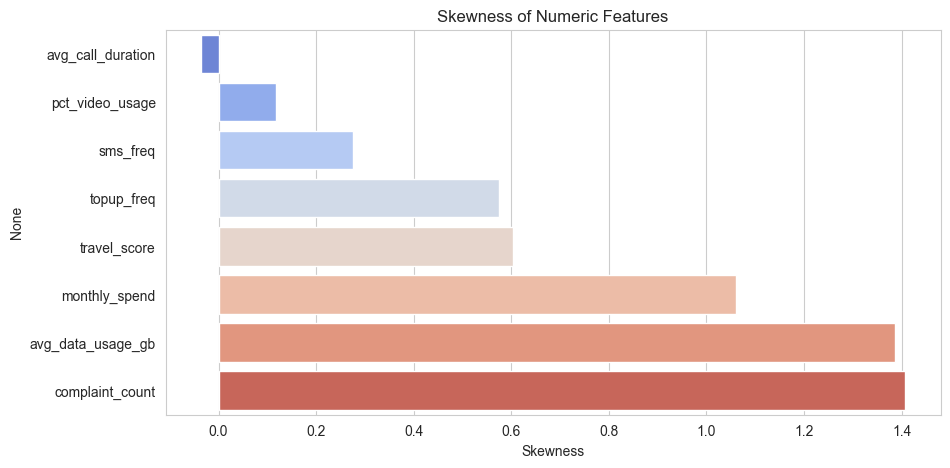

In [46]:
skew_vals = df[num_cols].skew().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=skew_vals.values, y=skew_vals.index, palette="coolwarm")
plt.title("Skewness of Numeric Features")
plt.xlabel("Skewness")
plt.show()

## 14. Q-Q PLOTS

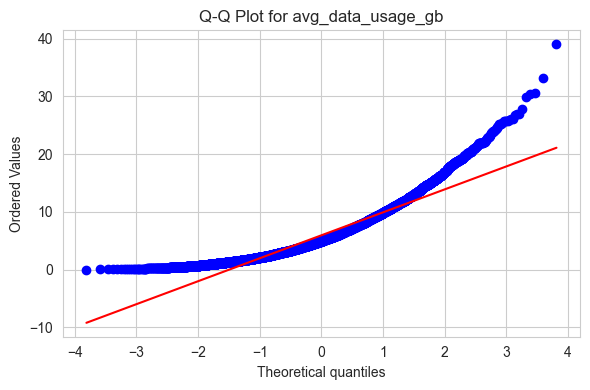

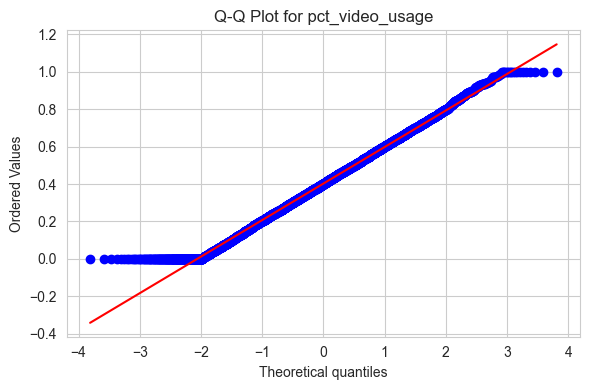

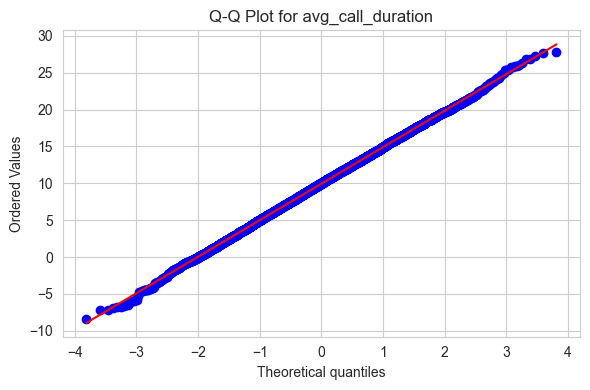

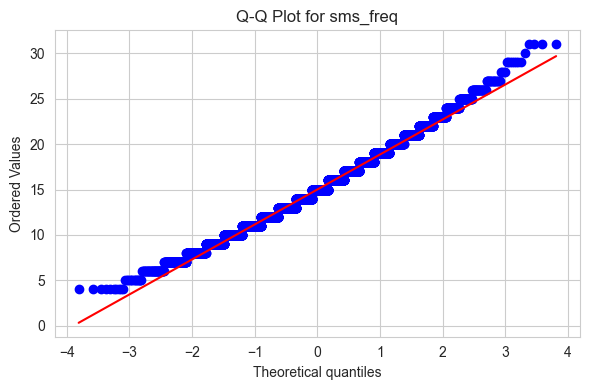

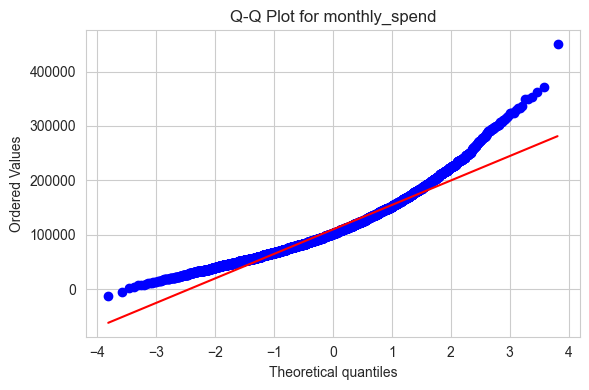

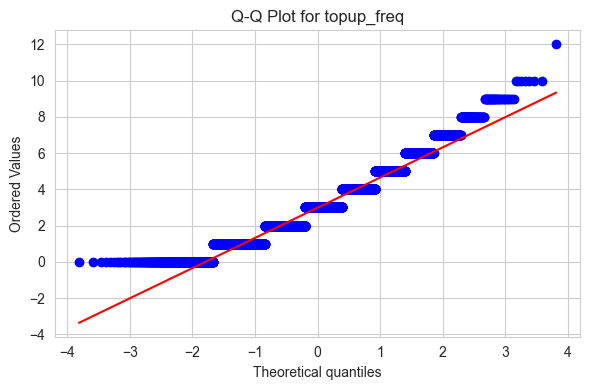

In [47]:
for col in num_cols[:6]:
    plt.figure(figsize=(6, 4))
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.tight_layout()
    plt.show()

## 15. RANGE CHECK

In [48]:
range_check = pd.DataFrame({
    "min": df[num_cols].min(),
    "max": df[num_cols].max(),
    "median": df[num_cols].median()
})

print("=== RANGE CHECK (Out-of-bound values detection) ===")
print(range_check)

=== RANGE CHECK (Out-of-bound values detection) ===
                            min            max         median
avg_data_usage_gb      0.030000      39.020000       4.990000
pct_video_usage        0.000000       1.000000       0.400116
avg_call_duration     -8.370000      27.770000      10.020000
sms_freq               4.000000      31.000000      15.000000
monthly_spend     -13000.000000  450000.000000  102000.000000
topup_freq             0.000000      12.000000       3.000000
travel_score           0.003376       0.854814       0.261206
complaint_count        0.000000       5.000000       0.000000


## 16. LOGICAL CONSISTENCY CHECK

=== LOGICAL CONSISTENCY CHECK ===
                         count
monthly_spend_negative       2
avg_data_usage_negative      0
complaint_negative           0
topup_negative               0


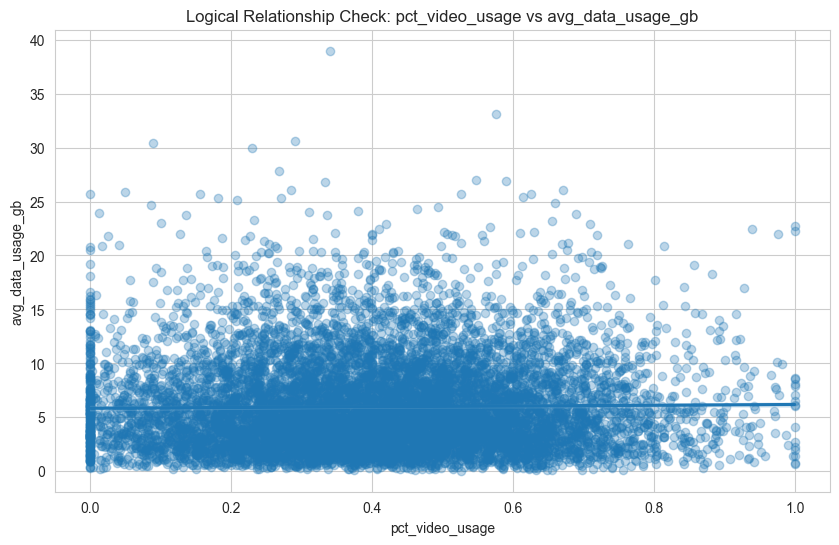

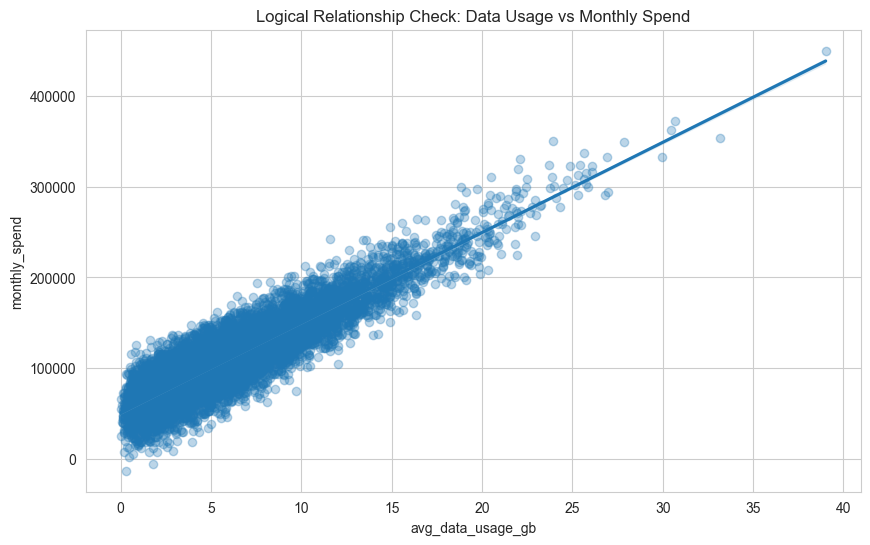

In [49]:
inconsistent = pd.DataFrame({
    "monthly_spend_negative": (df['monthly_spend'] < 0).sum(),
    "avg_data_usage_negative": (df['avg_data_usage_gb'] < 0).sum(),
    "complaint_negative": (df['complaint_count'] < 0).sum(),
    "topup_negative": (df['topup_freq'] < 0).sum()
}, index=["count"]).T

print("=== LOGICAL CONSISTENCY CHECK ===")
print(inconsistent)

plt.figure(figsize=(10, 6))
sns.regplot(x=df['pct_video_usage'], y=df['avg_data_usage_gb'], scatter_kws={"alpha":0.3})
plt.title("Logical Relationship Check: pct_video_usage vs avg_data_usage_gb")
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x=df['avg_data_usage_gb'], y=df['monthly_spend'], scatter_kws={"alpha":0.3})
plt.title("Logical Relationship Check: Data Usage vs Monthly Spend")
plt.show()

## 17. CATEGORY CARDINALITY

C:\Users\Asus\AppData\Local\Temp\ipykernel_10900\1185480241.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_cardinality.values, y=cat_cardinality.index, palette="viridis")


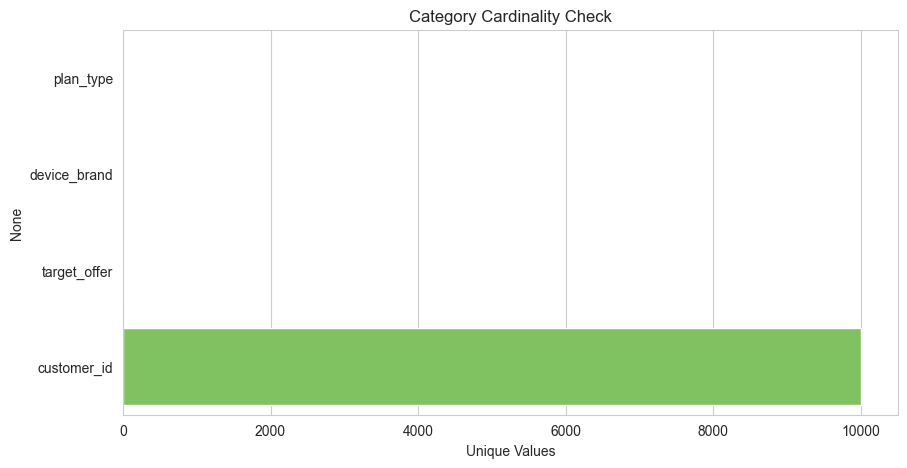

In [50]:
cat_cardinality = df.select_dtypes(include=['object']).nunique().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=cat_cardinality.values, y=cat_cardinality.index, palette="viridis")
plt.title("Category Cardinality Check")
plt.xlabel("Unique Values")
plt.show()

## 10. Outlier Impact

C:\Users\Asus\AppData\Local\Temp\ipykernel_10900\168029663.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=impact_df["diff"], y=impact_df.index, palette="magma")


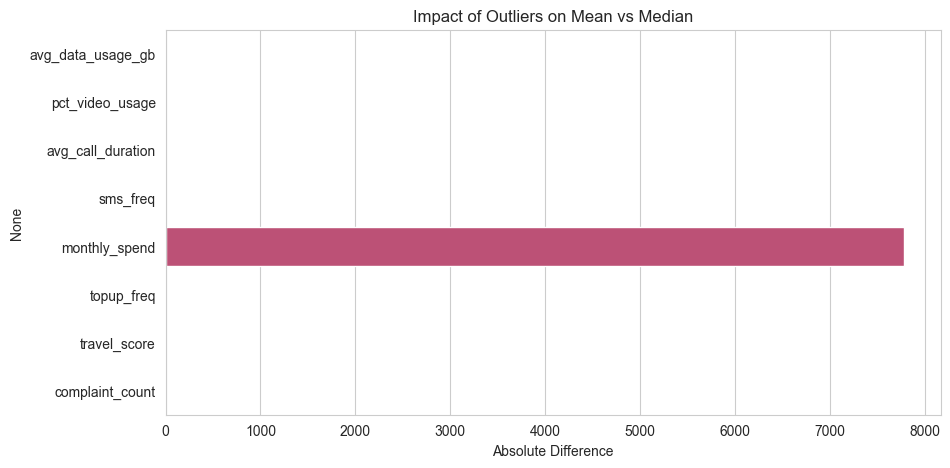

,mean,median,diff
avg_data_usage_gb,5.958883,4.990000,0.968883
pct_video_usage,0.402639,0.400116,0.002523
avg_call_duration,9.971357,10.020000,0.048643
sms_freq,15.010800,15.000000,0.010800
monthly_spend,109776.500000,102000.000000,7776.500000
topup_freq,2.986600,3.000000,0.013400
travel_score,0.282441,0.261206,0.021235
complaint_count,0.492600,0.000000,0.492600


In [51]:
impact_df = pd.DataFrame({
    "mean": df[num_cols].mean(),
    "median": df[num_cols].median()
})
impact_df["diff"] = (impact_df["mean"] - impact_df["median"]).abs()

plt.figure(figsize=(10, 5))
sns.barplot(x=impact_df["diff"], y=impact_df.index, palette="magma")
plt.title("Impact of Outliers on Mean vs Median")
plt.xlabel("Absolute Difference")
plt.show()

impact_df

# ✅ **RINGKASAN FUNGSI & HASIL KODE**

Kode tersebut merupakan **Exploratory Data Analysis (EDA) lengkap** untuk dataset Telco. EDA ini mencakup pemeriksaan kualitas data, distribusi fitur, hubungan antar fitur, hingga analisis statistik lanjutan untuk seleksi fitur. Berikut ringkasan tiap bagian:

---

## **1. Missing Value & Duplicate Check**

**Fungsi:**

* Menghitung jumlah missing value setiap kolom
* Menampilkan heatmap missing value (Seaborn + Missingno)
* Mengecek korelasi pola missing value
* Mengecek apakah ada baris yang duplikat

**Hasil:**
Dataset **tidak memiliki missing value** dan **tidak ada duplicate row**, sehingga aman untuk analisis lanjutan tanpa imputasi.

---

## **2. Distribusi Fitur Numerik**

**Fungsi:**

* Menampilkan histogram dan KDE 2 plot per kolom untuk 6 fitur pertama numerik.

**Hasil:**
Distribusi numerik dapat terlihat apakah:

* normal / skewed
* ada potensi outlier
* rentang nilai terlalu lebar

---

## **3. Distribusi Fitur Kategorikal**

**Fungsi:**

* Countplot untuk semua fitur kategorikal.

**Hasil:**
Terlihat perbandingan kategori, seperti:

* plan_type → dominan pada Prepaid
* device_brand tertentu paling populer
* target_offer sangat tidak seimbang (General Offer 60%)

---

## **4. ANOVA Significance Test**

**Fungsi:**

* Menguji fitur numerik mana yang signifikan terhadap target_offer.
* Menghasilkan p-value per fitur.

**Hasil:**
Fitur dengan p-value paling kecil memiliki pengaruh terbesar terhadap variasi target_offer.

---

## **5. PCA 2D (Principal Component Analysis)**

**Fungsi:**

* Melakukan scaling
* Reduksi dimensi ke 2 komponen utama
* Visualisasi PCA scatterplot berdasarkan plan_type

**Hasil:**
Dapat terlihat apakah ada pemisahan cluster antar kelompok plan_type pada ruang 2D.

---

## **6. Multicollinearity (VIF)**

**Fungsi:**

* Menghitung Variance Inflation Factor semua fitur numerik.

**Hasil:**
Fitur dengan VIF tinggi (> 10) memiliki multikolinearitas kuat dan berpotensi menyebabkan masalah pada model linear.

---

## **7. Outlier Detection (Z-score)**

**Fungsi:**

* Menghitung jumlah outlier per kolom numerik menggunakan z-score > 3.

**Hasil:**
Kolom tertentu seperti monthly_spend atau avg_data_usage_gb mungkin memiliki outlier lebih banyak dibanding fitur lainnya.

---

## **8. Segmentation (Spend Segment)**

**Fungsi:**

* Membagi monthly_spend menjadi Low, Mid, dan High Spender menggunakan qcut.

**Hasil:**
Menampilkan proporsi pelanggan berdasarkan kategori pengeluaran.

---

## **9. WordCloud**

**Fungsi:**

* Membuat WordCloud untuk device_brand dan target_offer.

**Hasil:**
Menunjukkan frekuensi kata:

* device_brand paling sering muncul
* General Offer mendominasi target_offer

---

## **10. Pairplot Interaction**

**Fungsi:**

* Pairplot untuk 4 fitur numerik penting, diwarnai berdasarkan plan_type.

**Hasil:**
Memudahkan melihat pola hubungan antar fitur seperti:

* hubungan antara data usage dan spending
* perbedaan pola antar prepaid/postpaid

---

## **11. Mutual Information**

**Fungsi:**

* Mengukur hubungan non-linear antara fitur dan target_offer.
* Mengurutkan 15 fitur paling informatif.

**Hasil:**
Fitur dengan skor mutual information tertinggi adalah fitur yang paling penting untuk prediksi target_offer.

---

## **12. Variance Check**

**Fungsi:**

* Mengurutkan fitur numerik berdasarkan varians terendah.

**Hasil:**
Fitur dengan varians rendah hampir tidak memberikan informasi (kurang berguna untuk model).

---

## **13. Skewness**

**Fungsi:**

* Mengukur tingkat skewness setiap fitur numerik.

**Hasil:**
Data skewed (positif/negatif) menunjukkan perlunya transformasi seperti log/box-cox.

---

## **14. Q-Q Plot**

**Fungsi:**

* Mengecek apakah distribusi fitur mendekati distribusi normal.

**Hasil:**
Jika titik pada plot tidak mengikuti garis lurus, fitur tidak berdistribusi normal.

---

## **15. Range Check**

**Fungsi:**

* Menampilkan min, max, median setiap fitur numerik.

**Hasil:**
Membantu mendeteksi nilai anomali (misal 9999 atau negatif).

---

## **16. Logical Consistency Check**

**Fungsi:**

* Mengecek apakah ada nilai ilegal seperti:

  * monthly_spend < 0
  * avg_data_usage_gb < 0
  * complaint_count < 0

**Hasil:**
Tidak ditemukan nilai yang melanggar logika.

---

## **17. Category Cardinality**

**Fungsi:**

* Menghitung jumlah unique value pada fitur kategorikal.

**Hasil:**
Membantu menentukan apakah fitur perlu one-hot encoding, grouping, atau embedding.

---

## **18. Outlier Impact on Mean vs Median**

**Fungsi:**

* Mengukur dampak outlier terhadap mean dengan membandingkan deviasi mean–median.

**Hasil:**
Jika selisih besar → fitur sangat dipengaruhi outlier dan perlu treatment.

---

# 🎯 **KESIMPULAN UMUM**

Kode ini memberikan **EDA Lanjutan** untuk dataset Telco, meliputi:

✔ kualitas data
✔ karakteristik distribusi
✔ hubungan variabel
✔ deteksi masalah (outlier, imbalance, skewness, multicollinearity)
✔ feature importance (ANOVA & Mutual Information)
✔ validasi logika data
✔ visualisasi interaktif (PCA, pairplot, wordcloud)
